
## Install and Import Modules
#### Install 
Add more if needed. I have provided some installation commands but you may need more if you do not have them installed yet.

In [25]:
%%capture
# %%capture is used to ignore output when content is boring.
# This is how you install modules from jupyter notebook instead of terminal. 
# Install the one you need or comment them out 
!pip3 install -U imageio-ffmpeg             #It contains VideoFileClip module needed in the next cell. 
!pip3 install opencv-contrib-python==4.1.0  #It contains opencv module from https://www.pyimagesearch.com/2018/09/19/pip-install-opencv/
!pip3 install ImageMagick

#### Import
if errors then you may need to go back and install it first. (Restarting Kernel might be necessary too)

In [2]:
# import the necessary packages
import numpy as np
import argparse
import cv2
import ipywidgets as ipw
import os
import random
from moviepy.editor import VideoFileClip,ImageSequenceClip, concatenate_videoclips, TextClip
from IPython.display import HTML, YouTubeVideo, display
import matplotlib.pyplot as plt
import shutil
%matplotlib inline

In [3]:
cv2.__version__    # Make sure version above 3.4.3 

'3.3.1'

---
## Watch Input <font color="violet"> Video </font>

Run the sample video I have provided first along with the whole tutorial, then

Try your own video:
- Place your video in the `Input_Video` folder
- Change <b>ONLY</b> the `video_name` in the cell below. 

In [4]:
video_name = "sample.mp4"
input_video_path = os.path.join("Input_Video", video_name)

#Erase this!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
video_name_part = video_name.split(".")    # sample & mp4 has been split
dest_path = os.path.join("Output_Video", video_name_part[0] + "_rotated." + video_name_part[1])
input_video_path = dest_path

# Watch Video
display(HTML("""
            <video width="960" height="540" controls>
              <source src="{0}">
            </video>
            """.format(input_video_path)))

---
## Needs Rotation?
I recorded my video with my phone in horizontal position. So I need to rotate it. Run the cells below if you also need rotation. Otherwise skip this section and go to next section: `Enumerate Frames of Video`

In [ ]:
def rotateImage(image, angle):
    """"
    Performs a counter clockwise rotation of the angle specified. Set Angle to 90 to rotate left or -90 for right  
    """

    (h, w) = image.shape[:2]        # get image height, width
    cx, cy = int(w/2), int(h/2)     # calculate the center of the original image    

    # Translate image center to the right before rotation
    tx = cy-cx     #translate in x
    ty = 0         #translate in y
    M  = np.float32([[1,0,tx],[0,1,ty]])
    image = cv2.warpAffine(image, M, (h,h))       # make square image (hxh)

    # Perform the counter clockwise rotation holding at the center
    center = (cy, cy)               # calculate new center of square image
    scale  = 1.0                    # keep same dimension in image
    M = cv2.getRotationMatrix2D(center, angle, scale)
    image = cv2.warpAffine(image, M, (h, h))

    # Translate image center to the top and crop bottom
    tx = 0          #translate in x
    ty = cx-cy      #translate in y
    M  = np.float32([[1,0,tx],[0,1,ty]])
    image = cv2.warpAffine(image, M, (h,w))       # this crops bottom as well

    return image

Let's implement it on the first frame of the video to make sure everything looks okay. Set `angle` to 90 to rotate left or -90 for right

In [ ]:
# Load video and Read frame
cap = cv2.VideoCapture(input_video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 0) #First frame
_, frame = cap.read() 

# Rotate to left
angle = 90
frame_rotated = rotateImage(frame , angle)

# Display
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
frame_rotated = cv2.cvtColor(frame_rotated,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(11, 5))   #width, height in inches
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(frame)

plt.subplot(1,2,2)
plt.title("Rotated")
plt.imshow(frame_rotated)

It works! So let's implemented in the whole video and place it in the `Output_Video` folder which we will create. Again set `angle` to 90 to rotate left or -90 for right

In [ ]:
# Create folder to place output videos at same level directory as input folder
try:
    os.mkdir("Output_Video")
except FileExistsError:
    print ("Output Folder is ready already")
    
# Rotate video
angle = 90
clip  = VideoFileClip(input_video_path)
video_clip = clip.fl_image(lambda image: rotateImage(image, angle))

# Save rotated video 
video_name_part = video_name.split(".")    # sample & mp4 has been split
dest_path = os.path.join("Output_Video", video_name_part[0] + "_rotated." + video_name_part[1])
%time video_clip.write_videofile(dest_path, audio=False)

Let's watch it now! And reassign the input video path to our new rotated video!

In [ ]:
# Reassign Input path to rotated video
input_video_path = dest_path

# Watch Video                                  
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(dest_path)) 

---
## Enumerate Frames of Video
We need to enumerate the frames of our video to know what frames will be with the "lights OFF". Run the cells below to know which frame intervals will remain in the "dark". 

<b>Tips and Tricks:</b> Define a class to keep track of data from previous frames. This will be useful for running our VideoFileClip object later

In [ ]:
class VideoTracker():
    def __init__(self):
        self.current_frame = 0 
    
    def plusOneFrame(self):
        self.current_frame = self.current_frame +1
        
        
videoInfo = VideoTracker()

In [ ]:
def addFrameNumber(image, frame_count, font_scale, color, thickness):
    """"
    Add frame number to an image.  
    """
        
    # Unpack and Define previously known data from video
    frame_num   = videoInfo.current_frame
    
    # Add Number
    h,w = image.shape[:2]
    box_startX, box_startY, box_endX, box_endY = 0, 0, int(0.5*w), int(0.2*h) # Box vertices follows golden ratio 
    image[box_startY: box_endY, box_startX:box_endX] = 0                      # Black rectangle in left corner 
    text = "Frame: "+ str(frame_num) + "/" + str(frame_count)
    text_startX, text_startY = 0, box_endY- int(box_endY*0.4)
    cv2.putText(image, text, (text_startX, text_startY),cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)
    
    # Update new data for next frame in video 
    videoInfo.plusOneFrame()
    
    return image

Let's first enumerate a random frame from our video to make sure everything looks ok. Set `font_scale`, `color`, and `thickness` to your taste to suit your video.

In [ ]:
# Load video
cap = cv2.VideoCapture(input_video_path)

# Get General Info
fps         = cap.get(cv2.CAP_PROP_FPS)      # OpenCV2 version 2 used "CV_CAP_PROP_FPS"
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration    = int(frame_count/fps)
width       = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # float
height      = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # float

# Read frame
videoInfo.current_frame = random.randint(0,frame_count-1)
cap.set(cv2.CAP_PROP_POS_FRAMES, videoInfo.current_frame)
_,frame=cap.read()

# Add frame number
font_scale, color, thickness= 2.5, (0, 255, 0), 10
frame = addFrameNumber(frame, frame_count, font_scale, color, thickness)

# Display
print('Frames Per Sec FPS = ' + str(fps))
print('Number of Frames   = ' + str(frame_count))
print('Duration [Sec]     = ' + str(duration))
minutes = int(duration/60)
seconds = duration%60
print('Duration [Min:Sec] = ' + str(minutes) + ':' + str(seconds))
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.show()

It works! So let's implement it in the whole video and place it in the Output_Video folder which we will create. <b>This may take a while...</b> 

In [ ]:
%%capture
# Create folder to place output videos at same level directory as input folder
try:
    os.mkdir("Output_Video")
except FileExistsError:
    print ("Output Folder is ready already")

# Add Frame Numbers to Video
font_scale, color, thickness = 2.5, (0, 255, 0), 10
videoInfo = VideoTracker()           # reset to begining
clip  = VideoFileClip(input_video_path)
video_clip = clip.fl_image(lambda image: addFrameNumber(image, frame_count, font_scale, color, thickness))

# Save Enumerated video 
video_name_part = video_name.split(".")    # sample & mp4 has been split
dest_path = os.path.join("Output_Video", video_name_part[0] + "_enumerated." + video_name_part[1])
%time video_clip.write_videofile(dest_path, audio=False)

Let's watch it now! Take note of the frame intervals you want to turn OFF the lights.

In [ ]:
# Watch Video 
dest_path = os.path.join("Output_Video", video_name_part[0] + "_enumerated." + video_name_part[1])
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(dest_path)) 

---
## HED Image Processing: "Turn OFF The Lights":

From the previous video we know now that frame intervals [93,184] , [465,1458], and [1588,1662] must be in the "dark." Let's explore on a random frame from our video our HED image processing option first.

For that, a neural network for edge detection called Hollistically-Nested Edge Detector (HED) will be used. This can be implemented with GPU but for simplicity we will use the OpenCV approach which uses CPU only. For more, check my list of edge detection techniques in my repo [EdgeDetection-and-ColorSpaces](https://github.com/laygond/EdgeDetection-and-ColorSpaces.git).

Start by loading Model and adding extra layer to model

In [6]:
# Create new Layer to add to current net
class CropLayer(object):
    def __init__(self, params, blobs):
        # initialize our starting and ending (x, y)-coordinates of
        # the crop
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0

    def getMemoryShapes(self, inputs):
        # the crop layer will receive two inputs -- we need to crop
        # the first input blob to match the shape of the second one,
        # keeping the batch size and number of channels
        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (H, W) = (targetShape[2], targetShape[3])

        # compute the starting and ending crop coordinates
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.startY = int((inputShape[2] - targetShape[2]) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H

        # return the shape of the volume (we'll perform the actual
        # crop during the forward pass
        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        # use the derived (x, y)-coordinates to perform the crop
        return [inputs[0][:, :, self.startY:self.endY,
                self.startX:self.endX]]


Define our pipeline workflow through which each image will be passed in

In [9]:
def hed_pipeline(image):
    
    # load model
    print("[INFO] loading edge detector...")
    protoPath = os.path.join("hed_model","deploy.prototxt")
    modelPath = os.path.join("hed_model","hed_pretrained_bsds.caffemodel")
    net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

    # register our new layer with the model
    cv2.dnn_registerLayer("Crop", CropLayer)

    # Preprocess image
    (height, width) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(width, height),
                                mean=(104.00698793, 116.66876762, 122.67891434),
                                swapRB=False, crop=False)

    # Run Model: Perform a forward pass of blob image
    print("[INFO] performing holistically-nested edge detection...")
    net.setInput(blob)
    hed = net.forward()
    hed = cv2.resize(hed[0, 0], (width, height))
    hed = (255 * hed).astype("uint8")
    
    return hed

Run image through our model pipeline.

In [ ]:
# Load video
cap = cv2.VideoCapture(input_video_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Read frame
frame_num = random.randint(0,frame_count-1)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
_,frame=cap.read()

# Apply HED to frame
frame = hed_pipeline(frame)

# Display
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.show()

[INFO] loading edge detector...
[INFO] performing holistically-nested edge detection...


### Split & Concatenate Small Clips
Frame intervals [93,184] , [465,1458], and [1588,1662] must be in the "dark."

In [20]:
# Create folder to place output videos at same level directory as input folder
try:
    os.mkdir("Output_Video")
except FileExistsError:
    print ("Output Folder is ready already")

    
# Transform frame numbers into seconds for 'Video File Clip'
clip   = VideoFileClip(input_video_path)
dark_time  = np.floor(np.array([[93,184] , [465,1458], [1588,1662]]) / clip.fps * 10)/10  # one decimal place only 
light_time = np.reshape(np.hstack((np.array([0.0]),dark_time.flatten()[:-1] )), (3, 2))   # append zero in front, delete last time value, reshape
print("\n Dart Time Intervals \n", dark_time,"\n\n Light Time Intervals \n", light_time, "\n")


# Split Video into dark and light clips
light_clips = []
for interval in light_time:
    start, end = interval
    light_clips.append(clip.subclip(start,end))

dark_clips = []
for interval in dark_time:
    start, end = interval
    sub_clip   = clip.subclip(start,end)
    dark_clip  = sub_clip#.fl_image(hed_pipeline)
    dark_clips.append(dark_clip)

    
# Concatenate Clips
video_clips = [pair_clips for pair_clips in zip(light_clips, dark_clips)] # list of tuples
video_clips = [element for tupl in video_clips for element in tupl]       # flatten tuples (one dimensional list)
video_clip  = concatenate_videoclips(video_clips)
    
    
# Save video 
video_name_part = video_name.split(".")    # sample & mp4 has been split
dest_path = os.path.join("Output_Video", video_name_part[0] + "_output." + video_name_part[1])
%time video_clip.write_videofile(dest_path, audio=False)


Output Folder is ready already

 Dart Time Intervals 
 [[  3.1   6.1]
 [ 15.5  48.6]
 [ 52.9  55.4]] 

 Light Time Intervals 
 [[  0.    3.1]
 [  6.1  15.5]
 [ 48.6  52.9]]
[MoviePy] >>>> Building video Output_Video/sample_output.mp4
[MoviePy] Writing video Output_Video/sample_output.mp4


100%|█████████▉| 1662/1663 [03:52<00:00,  5.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Output_Video/sample_output.mp4 

CPU times: user 6.29 s, sys: 7.49 s, total: 13.8 s
Wall time: 3min 56s


Let's watch it now!

In [21]:
# Watch Video 
dest_path = os.path.join("Output_Video", video_name_part[0] + "_output." + video_name_part[1])
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(dest_path)) 

---
## Add Border and Text Watermark 

Modify the `add_border and text_watermark` function to your taste. It's just two simple OpenCV function.

In [30]:
def add_border_and_text_watermark(image): 
    # Add Border
    (height, width) = image.shape[:2]
    color = [0,0,0]     # Black Borders
    image = cv2.copyMakeBorder(image, top=int(0.15*height), bottom=int(0.15*height), left=0, right=0, borderType=cv2.BORDER_CONSTANT, value=color)
    
    # Add Text Watermark
    font_scale, color, thickness= 1.2, (255, 255, 255), 3
    text = "@caic.espol"
    text_startX, text_startY = int(width/2+ width*0.2), height
    cv2.putText(image, text, (text_startX, text_startY),cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

    return image

First let's try it in one image

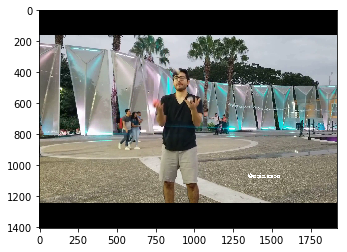

In [31]:
output_video_path = os.path.join("Output_Video", video_name_part[0] + "_output." + video_name_part[1])

# Load video
cap = cv2.VideoCapture(output_video_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Read frame
frame_num = random.randint(0,frame_count-1)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
_,frame=cap.read()

# Add black border (Movie style) and my Text Watermark
frame = add_border_and_text_watermark(frame)

# Display
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.show()

I works! Let's make a video out of it

In [34]:
%%capture
# Add Border to Video
clip  = VideoFileClip(output_video_path)
video_clip = clip.fl_image(add_border_and_text_watermark)

# Save Movie Style Video 
video_name_part = video_name.split(".")    # sample & mp4 has been split
dest_path = os.path.join("Output_Video", video_name_part[0] + "_output__movie_style." + video_name_part[1])
%time video_clip.write_videofile(dest_path, audio=False)

100%|█████████▉| 1662/1663 [04:36<00:00,  4.53it/s]


In [35]:
# Watch Video 
dest_path = os.path.join("Output_Video", video_name_part[0] + "_output__movie_style." + video_name_part[1])
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(dest_path)) 

---
## Add Temporal Text

In [54]:
#TODO: CREATE GENERAL TEXT INSERTION (NOT INTRO)  
def add_IntroText(image):
    (height, width) = image.shape[:2]
    font_scale, color, thickness= 2, (255, 255, 255), 5

    text = "Up for the Challenge?!"
    text_startX, text_startY = int(width/2- width*0.15), int(0.07*height)
    cv2.putText(image, text, (text_startX, text_startY),cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

    text = "Follow the Pink Ball"
    text_startX, text_startY = int(width/2- width*0.15), int(height- 0.05*height)
    cv2.putText(image, text, (text_startX, text_startY),cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

    return image

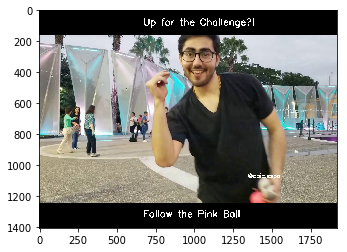

In [53]:
# Load video
cap = cv2.VideoCapture(os.path.join("Output_Video", video_name_part[0] + "_output__movie_style." + video_name_part[1]))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Read frame
frame_num = random.randint(0,frame_count-1)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
_,frame=cap.read()

# Add black border (Movie style) and my Text Watermark
frame = add_IntroText(frame)

# Display
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.show()

In [ ]:
# Add Intro Text for half the duration of video
clip  = VideoFileClip(os.path.join("Output_Video", video_name_part[0] + "_output__movie_style." + video_name_part[1]))
video_clip = clip.subclip.(0,int(clip.duration/2).fl_image(add_IntroText)

# Save Enumerated video 
video_name_part = video_name.split(".")    # sample & mp4 has been split
dest_path = os.path.join("Output_Video", video_name_part[0] + "_enumerated." + video_name_part[1])
%time video_clip.write_videofile(dest_path, audio=False)

In [ ]:
# Watch Video 
dest_path = os.path.join("Output_Video", video_name_part[0] + "_output__movie_style." + video_name_part[1])
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(dest_path)) 

---
## Add Question Frame

In [5]:
my_clip = VideoFileClip(os.path.join("Output_Video", video_name_part[0] + "_output." + video_name_part[1]))

w,h = my_clip.size  # size of the clip

# A CLIP WITH A TEXT AND A BLACK SEMI-OPAQUE BACKGROUND

txt = TextClip("THE WATERMARK TEXT", font='Amiri-regular',
                   color='white',fontsize=24)

txt_col = txt.on_color(size=(my_clip.w + txt.w,txt.h-10),
                  color=(0,0,0), pos=(6,'center'), col_opacity=0.6)

# This example demonstrates a moving text effect where the position is a function of time(t, in seconds).
# You can fix the position of the text manually, of course. Remember, you can use strings,
# like 'top', 'left' to specify the position
txt_mov = txt_col.set_pos( lambda t: (max(w/30,int(w-0.5*w*t)),
                                  max(5*h/6,int(100*t))) )

# Write the file to disk
final = CompositeVideoClip([my_clip,txt_mov])
final.duration = my_clip.duration
#final.write_videofile("OUT.mp4",fps=24,codec='libx264')
    
# Save video 
video_name_part = video_name.split(".")    # sample & mp4 has been split
dest_path = os.path.join("Output_Video", video_name_part[0] + "_output_text." + video_name_part[1])
%time final.write_videofile(dest_path, fps=24, audio=False)



[MoviePy] This command returned an error !

OSError: MoviePy Error: creation of None failed because of the following error:

convert: not authorized `@/tmp/tmpsdmgwy3s.txt' @ error/property.c/InterpretImageProperties/3405.
convert: no images defined `PNG32:/tmp/tmpbsd1ahnb.png' @ error/convert.c/ConvertImageCommand/3210.
.

.This error can be due to the fact that ImageMagick is not installed on your computer, or (for Windows users) that you didn't specify the path to the ImageMagick binary in file conf.py, or.that the path you specified is incorrect

In [ ]:
# Watch Video 
dest_path = os.path.join("Output_Video", video_name_part[0] + "_text." + video_name_part[1])
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(dest_path)) 